<img src=https://www.udc.es/export/sites/udc/silazarillo/_galeria_imgs/03_Simbolo_logo_cor.png_2063069294.png width="300" align="left">
<br />

# PAN: Homework \#2 - Membership inference
### Name and surname: Pedro Otero García

#### <font color=green>*Máster Inter-Universitario en Ciberseguridad*</font>

## Statement

In this homework, you should implement a membership inference attack on two different models, a Multi-Layer Perceptron (MLP) and a Convolutional Neural Network (CNN) both trained on the CIFAR10 image dataset we already used in Labwork 8.

As a reminder, such a dataset consists of 60,000 real photographs divided into 10 classes. The classes include common objects such as airplanes, automobiles, birds, cats, etc. The dataset is already divided into a training set of 50,000 images and a test set consisting of the remaining 10,000 images. The images contain 3 channels (red, green and blue) and have a resolution of 32 x 32 pixels.

In the next sections, you are provided with a skeleton of the steps you must follow to perform the attack

## Load data

Firstly, you must load the dataset. Take into account that the prebuilt data division (training and testing) should be adjusted in order to use approximately 30,000 images (50%) for training/testing and the rest to build the shadow models. The train/test split should be 75% and 25%, respectively.

**Warning!** CIFAR10 is available under ART package as one of the demonstrations dataset. However, it seems that it takes a lot of memory to load it. Therefore, I recommend you to load it from Tensorflow/Keras, as in previous Labs.

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_labels = train_labels.ravel()
test_labels = test_labels.ravel()

In [4]:
ds_images = np.concatenate((train_images, test_images), axis=0)
ds_labels = np.concatenate((train_labels, test_labels), axis=0)

In [5]:
half = round(len(ds_images)/2)
x_target, x_shadow = ds_images[:half], ds_images[half:]
y_target, y_shadow = ds_labels[:half], ds_labels[:half]

three_thirds = round(3/4*half)
x_target_train = x_target[:three_thirds]
x_target_test = x_target[three_thirds:]
y_target_train = y_target[:three_thirds]
y_target_test = y_target[three_thirds:]

In [6]:
print(f'Training sample: {len(x_target_train)}\nTest sample: {len(x_target_test)}\nShadow sample: {len(x_shadow)}')

Training sample: 22500
Test sample: 7500
Shadow sample: 30000


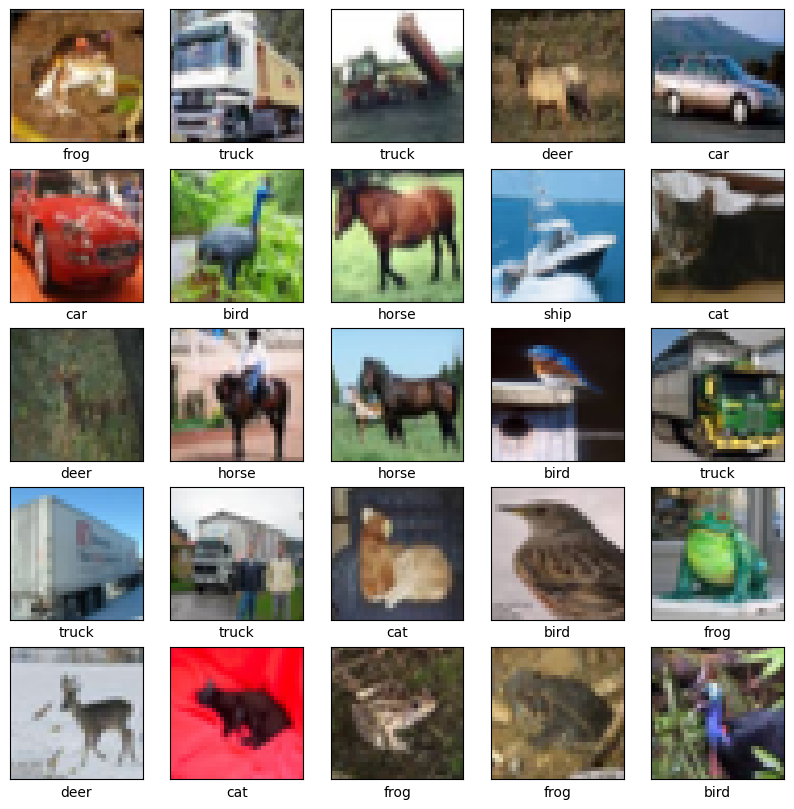

In [7]:
# The name associated with each of the classes is specified in order to display them graphically.
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]]) # Displays as x-axis label the name of the image class

## Train models

Now, you should build and train both MLP and CNN models... You can adapt the models used in previous labs!

**Warning!** It may take some time to train the models. If you opt to save them to re-run the experiments you should also save the dataset splits. Otherwise, the experiment won't be the same (diferent training/testing and shadow samples)

In [8]:
# You should disable Tensorflow eager execution, otherwise ART attack won't work!!!
from torch import nn
import torch as th
from torch.optim import Adam
tf.compat.v1.disable_eager_execution()

### MLP

In [25]:
def mlp3():
    # We first define the network layers
    model1 = models.Sequential()
    model1.add(layers.Flatten(input_shape=(32,32,3)))
    model1.add(layers.Dense(15, activation='relu')) # Densely connected layer with 15 neurons
    model1.add(layers.Dense(10, activation='relu'))                     # Densely connected layer with 10 neurons
    model1.add(layers.Dense(10, activation='softmax'))                   # Densely concected layer with 3 neurons (outputs)
    # Subsequently, we specify the optimizer to be used and its hyperparameters
    #opt = keras.optimizers.Adam(learning_rate=0.001) 
    # Finally, we define the features for the training process:
    # optimizer, erorr function, evaluation metrics, etc.
    model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    return model1

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

def mlp():
    # Crear el modelo secuencial de Keras
    model = Sequential()

    # Capa de entrada: Aplanar los datos de entrada (32x32x3)
    model.add(Flatten(input_shape=(32, 32, 3)))

    # Capa oculta 1: 15 neuronas con activación relu
    model.add(Dense(15, activation='relu'))

    # Capa oculta 2: 10 neuronas con activación relu
    model.add(Dense(10, activation='relu'))

    # Capa de salida: 10 neuronas (clases) con activación softmax
    model.add(Dense(10, activation='softmax'))

    # Compilar el modelo con configuraciones para entrenamiento
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [26]:
model_mlp = mlp()
model_mlp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 15)                46095     
                                                                 
 dense_3 (Dense)             (None, 10)                160       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
Total params: 46365 (181.11 KB)
Trainable params: 46365 (181.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
epochs = 5
batch_size = 100
model_mlp.fit(x_target_train, y_target_train, epochs=epochs, batch_size=batch_size, validation_data=(x_target_test, y_target_test))

Train on 22500 samples, validate on 7500 samples
Epoch 1/5
  100/22500 [..............................] - ETA: 16s - loss: 2.3952 - accuracy: 0.1500

2023-12-26 22:20:03.572057: W tensorflow/c/c_api.cc:305] Operation '{name:'training_8/Adam/dense_2_1/bias/v/Assign' id:2573 op device:{requested: '', assigned: ''} def:{{{node training_8/Adam/dense_2_1/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_8/Adam/dense_2_1/bias/v, training_8/Adam/dense_2_1/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


22500/22500 [==============================] - ETA: 0s - loss: 2.2665 - accuracy: 0.1246

/home/pedro/anaconda3/envs/munics/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-12-26 22:20:04.966359: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_4/mul' id:2460 op device:{requested: '', assigned: ''} def:{{{node loss_4/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_4/mul/x, loss_4/dense_4_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


22500/22500 [==============================] - 2s 75us/sample - loss: 2.2665 - accuracy: 0.1246 - val_loss: 2.2166 - val_accuracy: 0.1477
Epoch 2/5
22500/22500 [==============================] - 1s 63us/sample - loss: 2.1383 - accuracy: 0.1887 - val_loss: 2.0568 - val_accuracy: 0.2057
Epoch 3/5
22500/22500 [==============================] - 1s 66us/sample - loss: 2.0412 - accuracy: 0.2204 - val_loss: 2.0438 - val_accuracy: 0.2120
Epoch 4/5
22500/22500 [==============================] - 2s 69us/sample - loss: 2.0145 - accuracy: 0.2336 - val_loss: 2.0078 - val_accuracy: 0.2332
Epoch 5/5
22500/22500 [==============================] - 1s 61us/sample - loss: 2.0005 - accuracy: 0.2394 - val_loss: 1.9873 - val_accuracy: 0.2317


### CNN

In [12]:
def cnn():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(10))
    opt = keras.optimizers.legacy.Adam(learning_rate=0.001) 
    model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model

In [13]:
def cnn1():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])    
    return model

In [14]:
model_cnn = cnn1()
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [15]:
epochs = 5
batch_size = 100
model_cnn.fit(x_target_train, y_target_train, epochs=epochs, batch_size=batch_size, validation_data=(x_target_test, y_target_test))

Train on 22500 samples, validate on 7500 samples


2023-12-26 21:51:59.006135: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


2023-12-26 21:51:59.373117: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/conv2d/bias/v/Assign' id:335 op device:{requested: '', assigned: ''} def:{{{node training/Adam/conv2d/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/conv2d/bias/v, training/Adam/conv2d/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/5
22500/22500 [==============================] - ETA: 0s - loss: 1.8352 - accuracy: 0.3155

/home/pedro/anaconda3/envs/munics/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-12-26 21:52:35.871929: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:183 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


22500/22500 [==============================] - 40s 2ms/sample - loss: 1.8352 - accuracy: 0.3155 - val_loss: 1.5411 - val_accuracy: 0.4400
Epoch 2/5
22500/22500 [==============================] - 37s 2ms/sample - loss: 1.4710 - accuracy: 0.4675 - val_loss: 1.3729 - val_accuracy: 0.5012
Epoch 3/5
22500/22500 [==============================] - 40s 2ms/sample - loss: 1.3408 - accuracy: 0.5192 - val_loss: 1.2600 - val_accuracy: 0.5505
Epoch 4/5
22500/22500 [==============================] - 43s 2ms/sample - loss: 1.2295 - accuracy: 0.5601 - val_loss: 1.2010 - val_accuracy: 0.5613
Epoch 5/5
22500/22500 [==============================] - 43s 2ms/sample - loss: 1.1528 - accuracy: 0.5930 - val_loss: 1.1230 - val_accuracy: 0.5999


In [28]:
test_loss, test_acc = model_cnn.evaluate(test_images,  test_labels, verbose=0)
print('Accuray (test CNN):', test_acc)

Accuray (test CNN): 0.5922


In [29]:
test_loss, test_acc = model_mlp.evaluate(test_images,  test_labels, verbose=0)
print('Accuray (test MLP):', test_acc)

Accuray (test MLP): 0.2314


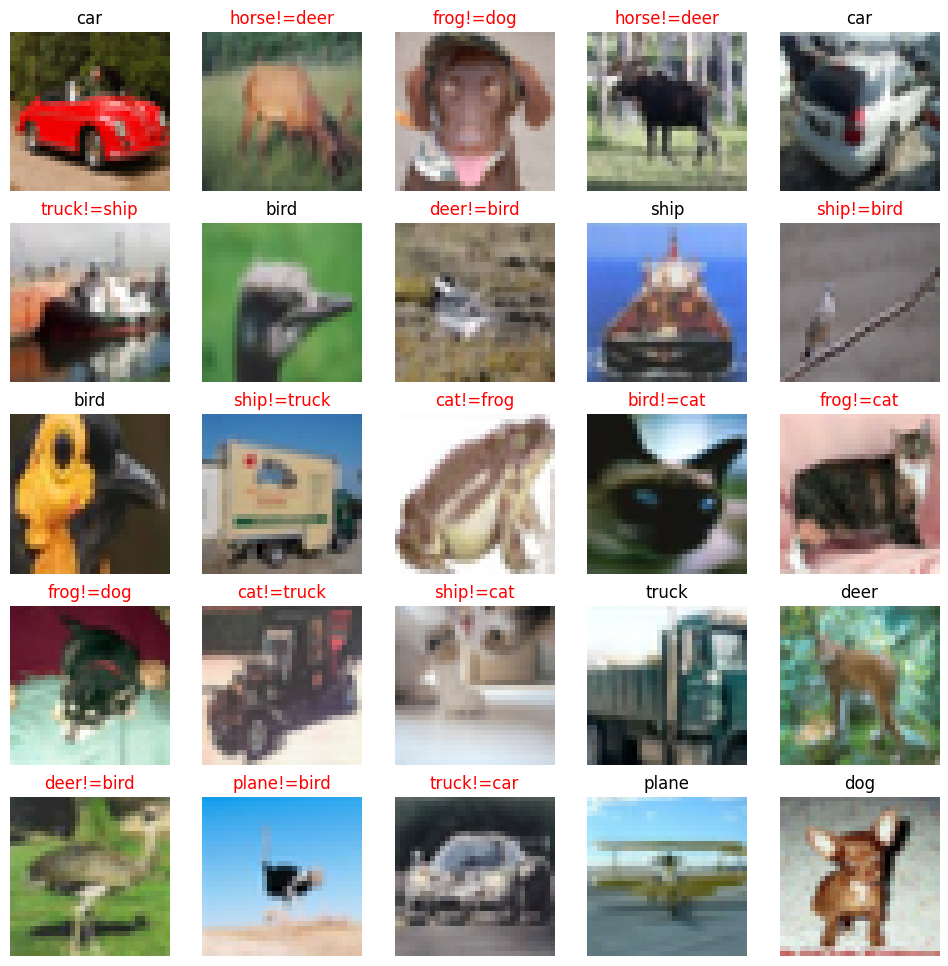

In [30]:
plt.figure(figsize=(12,12))
for i in range(25):
    index = random.randint(0, test_images.shape[0]) # An image number is chosen at random
    image = test_images[index:index+1]

    plt.subplot(5, 5, i+1) 
    plt.imshow(image[0])       # Randomly selected image is displayed
    plt.axis('off')

    pred = model_cnn.predict(image)  # The model prediction for the chosen image is obtained
    class_pred = np.argmax(pred) # The class for the chosen image is obtained
            
    if test_labels[index] == class_pred:   # If the predicted class is successful: only the class name is displayed in the title
        plt.title(class_names[class_pred]) 
    else:                                  # If there is an error in the classification: both classes are shown in red in the title
        plt.title(class_names[class_pred] + "!=" + class_names[test_labels[index]], color='#ff0000') 

/home/pedro/anaconda3/envs/munics/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-12-26 21:55:30.710140: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1/BiasAdd' id:125 op device:{requested: '', assigned: ''} def:{{{node dense_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_1/MatMul, dense_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


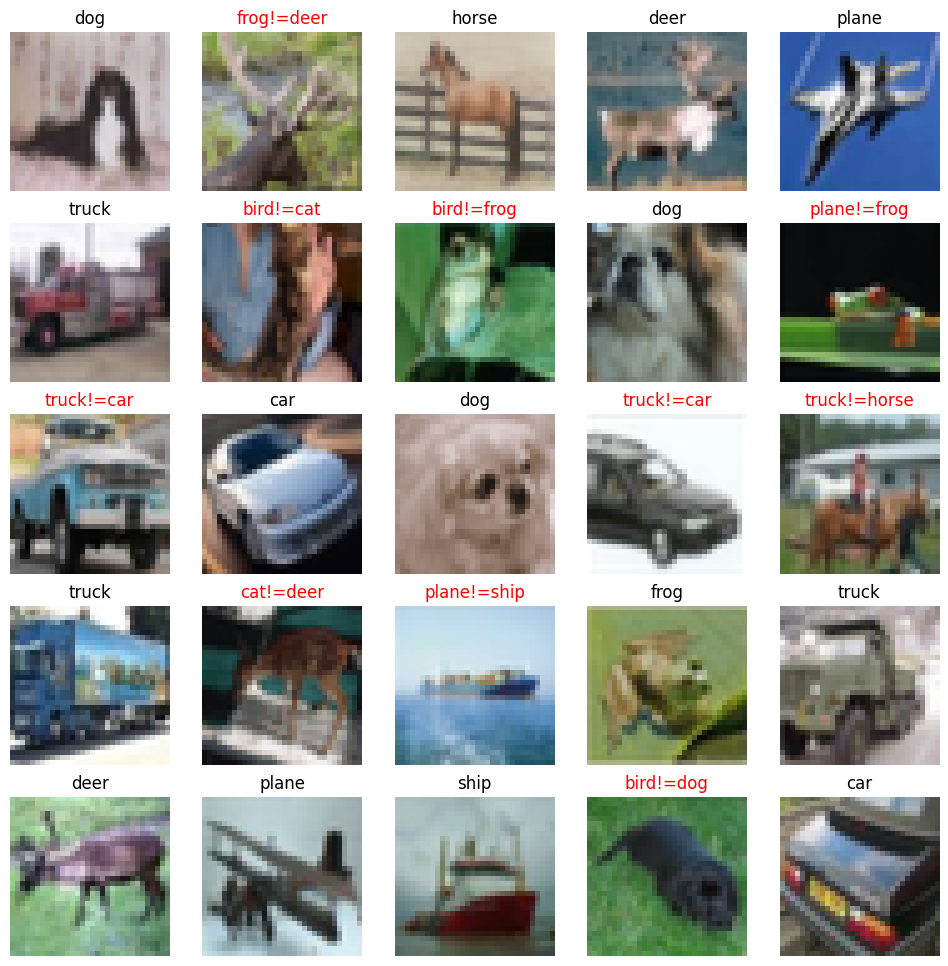

In [17]:
plt.figure(figsize=(12,12))
for i in range(25):
    index = random.randint(0, test_images.shape[0]) # An image number is chosen at random
    image = test_images[index:index+1]

    plt.subplot(5, 5, i+1) 
    plt.imshow(image[0])       # Randomly selected image is displayed
    plt.axis('off')

    pred = model_cnn.predict(image)  # The model prediction for the chosen image is obtained
    class_pred = np.argmax(pred) # The class for the chosen image is obtained
            
    if test_labels[index] == class_pred:   # If the predicted class is successful: only the class name is displayed in the title
        plt.title(class_names[class_pred]) 
    else:                                  # If there is an error in the classification: both classes are shown in red in the title
        plt.title(class_names[class_pred] + "!=" + class_names[test_labels[index]], color='#ff0000') 

In [18]:
from art.estimators.classification import KerasClassifier

# Usar la salida de la última capa densa como características
cnn_features = model_cnn.predict(x_target_train)  # Usar x_train como ejemplo

# Convertir el clasificador sklearn en un estimador Art
art_classifier = KerasClassifier(model_cnn)

/home/pedro/anaconda3/envs/munics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
# Usar la salida de la última capa densa como características
cnn_features = model_mlp.predict(x_target_train)  # Usar x_train como ejemplo

# Convertir el clasificador sklearn en un estimador Art
art_classifier_mlp = KerasClassifier(model_mlp)

/home/pedro/anaconda3/envs/munics/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-12-26 22:27:15.981570: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_4_1/Softmax' id:2402 op device:{requested: '', assigned: ''} def:{{{node dense_4_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_4_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


## Train shadow models

You should train three shadow models for each one of your classifiers (MLP and CNN), using a shadow dataset based on the data you have previously isolated for this purpose.

Compute the accuracy obtained for such models!

In [19]:
from art.attacks.inference.membership_inference import ShadowModels
from art.utils import to_categorical

shadow_models = ShadowModels(art_classifier, num_shadow_models=3)

shadow_dataset = shadow_models.generate_shadow_dataset(x_shadow, to_categorical(y_shadow, 10))
(member_x, member_y, member_predictions), (nonmember_x, nonmember_y, nonmember_predictions) = shadow_dataset

# Shadow models' accuracy
print([sm.model.evaluate(x_target_test, y_target_test) for sm in shadow_models.get_shadow_models()])

Train on 15000 samples


2023-12-26 21:58:18.016002: W tensorflow/c/c_api.cc:305] Operation '{name:'total_2/Assign' id:1084 op device:{requested: '', assigned: ''} def:{{{node total_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_2, total_2/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/20
15000/15000 [==============================] - 11s 702us/sample - loss: 2.3033 - accuracy: 0.0985
Epoch 2/20
15000/15000 [==============================] - 9s 633us/sample - loss: 2.3027 - accuracy: 0.0995
Epoch 3/20
15000/15000 [==============================] - 9s 633us/sample - loss: 2.3027 - accuracy: 0.1027
Epoch 4/20
15000/15000 [==============================] - 10s 639us/sample - loss: 2.3026 - accuracy: 0.1007
Epoch 5/20
15000/15000 [==============================] - 10s 645us/sample - loss: 2.3026 - accuracy: 0.1017
Epoch 6/20
15000/15000 [==============================] - 10s 641us/sample - loss: 2.3026 - accuracy: 0.1023
Epoch 7/20
15000/15000 [==============================] - 10s 646us/sample - loss: 2.3026 - accuracy: 0.0996
Epoch 8/20
15000/15000 [==============================] - 10s 636us/sample - loss: 2.3026 - accuracy: 0.0990
Epoch 9/20
15000/15000 [==============================] - 9s 630us/sample - loss: 2.3026 - accuracy: 0.0991
Epoch 10/20
15000/1500

/home/pedro/anaconda3/envs/munics/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-12-26 22:01:31.496069: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1_1/BiasAdd' id:674 op device:{requested: '', assigned: ''} def:{{{node dense_1_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_1_1/MatMul, dense_1_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Train on 15000 samples
Epoch 1/20


2023-12-26 22:01:36.304813: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_2/mul' id:1137 op device:{requested: '', assigned: ''} def:{{{node loss_2/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_2/mul/x, loss_2/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-26 22:01:36.393244: W tensorflow/c/c_api.cc:305] Operation '{name:'training_4/Adam/conv2d_2_2/kernel/m/Assign' id:1914 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/conv2d_2_2/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/conv2d_2_2/kernel/m, training_4/Adam/conv2d_2_2/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigge

15000/15000 [==============================] - 10s 637us/sample - loss: 2.3042 - accuracy: 0.1003
Epoch 2/20
15000/15000 [==============================] - 9s 612us/sample - loss: 2.3027 - accuracy: 0.0988
Epoch 3/20
15000/15000 [==============================] - 9s 624us/sample - loss: 2.3027 - accuracy: 0.1031
Epoch 4/20
15000/15000 [==============================] - 9s 629us/sample - loss: 2.3027 - accuracy: 0.1031
Epoch 5/20
15000/15000 [==============================] - 9s 627us/sample - loss: 2.3027 - accuracy: 0.1031
Epoch 6/20
15000/15000 [==============================] - 9s 616us/sample - loss: 2.3026 - accuracy: 0.1031
Epoch 7/20
15000/15000 [==============================] - 11s 711us/sample - loss: 2.3026 - accuracy: 0.1011
Epoch 8/20
15000/15000 [==============================] - 9s 633us/sample - loss: 2.3026 - accuracy: 0.1031
Epoch 9/20
15000/15000 [==============================] - 11s 728us/sample - loss: 2.3026 - accuracy: 0.1031
Epoch 10/20
15000/15000 [===========

2023-12-26 22:05:15.561038: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1_2/BiasAdd' id:1004 op device:{requested: '', assigned: ''} def:{{{node dense_1_2/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_1_2/MatMul, dense_1_2/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Train on 15000 samples


2023-12-26 22:05:21.310410: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_3/mul' id:1467 op device:{requested: '', assigned: ''} def:{{{node loss_3/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_3/mul/x, loss_3/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-26 22:05:21.428005: W tensorflow/c/c_api.cc:305] Operation '{name:'training_6/Adam/conv2d_5/bias/v/Assign' id:2200 op device:{requested: '', assigned: ''} def:{{{node training_6/Adam/conv2d_5/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_6/Adam/conv2d_5/bias/v, training_6/Adam/conv2d_5/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in th

Epoch 1/20
15000/15000 [==============================] - 12s 830us/sample - loss: 2.3036 - accuracy: 0.1007
Epoch 2/20
15000/15000 [==============================] - 12s 809us/sample - loss: 2.3028 - accuracy: 0.1001
Epoch 3/20
15000/15000 [==============================] - 10s 641us/sample - loss: 2.3026 - accuracy: 0.1002
Epoch 4/20
15000/15000 [==============================] - 10s 667us/sample - loss: 2.3027 - accuracy: 0.0987
Epoch 5/20
15000/15000 [==============================] - 10s 643us/sample - loss: 2.3026 - accuracy: 0.0991
Epoch 6/20
15000/15000 [==============================] - 9s 632us/sample - loss: 2.3026 - accuracy: 0.0977
Epoch 7/20
15000/15000 [==============================] - 9s 627us/sample - loss: 2.3026 - accuracy: 0.1002
Epoch 8/20
15000/15000 [==============================] - 10s 685us/sample - loss: 2.3026 - accuracy: 0.1015
Epoch 9/20
15000/15000 [==============================] - 10s 680us/sample - loss: 2.3026 - accuracy: 0.0999
Epoch 10/20
15000/150

2023-12-26 22:08:45.901066: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1_3/BiasAdd' id:1334 op device:{requested: '', assigned: ''} def:{{{node dense_1_3/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_1_3/MatMul, dense_1_3/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/pedro/anaconda3/envs/munics/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-12-26 22:08:52.258093: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_1/mul' id:807 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_ma

[[2.3026937175750732, 0.09746667], [2.3024553265889485, 0.10306667], [2.3027178131103514, 0.10306667]]


In [33]:
shadow_models_mlp = ShadowModels(art_classifier_mlp, num_shadow_models=3)

shadow_dataset_mlp = shadow_models_mlp.generate_shadow_dataset(x_shadow, to_categorical(y_shadow, 10))
(member_mlp_x, member_mlp_y, member_mlp_predictions), (nonmember_mlp_x, nonmember_mlp_y, nonmember_mlp_predictions) = shadow_dataset_mlp

# Shadow models' accuracy
print([sm.model.evaluate(x_target_test, y_target_test) for sm in shadow_models_mlp.get_shadow_models()])

Train on 15000 samples


2023-12-26 22:32:00.167589: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_4_5/kernel/Assign' id:3894 op device:{requested: '', assigned: ''} def:{{{node dense_4_5/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_4_5/kernel, dense_4_5/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/20
15000/15000 [==============================] - 1s 57us/sample - loss: 2.3135 - accuracy: 0.0945
Epoch 2/20
15000/15000 [==============================] - 1s 48us/sample - loss: 2.3027 - accuracy: 0.0986
Epoch 3/20
15000/15000 [==============================] - 1s 51us/sample - loss: 2.3027 - accuracy: 0.1015
Epoch 4/20
15000/15000 [==============================] - 1s 71us/sample - loss: 2.3027 - accuracy: 0.0996
Epoch 5/20
15000/15000 [==============================] - 1s 48us/sample - loss: 2.3026 - accuracy: 0.0988
Epoch 6/20
15000/15000 [==============================] - 1s 45us/sample - loss: 2.3026 - accuracy: 0.0973
Epoch 7/20
15000/15000 [==============================] - 1s 48us/sample - loss: 2.3026 - accuracy: 0.0996
Epoch 8/20
15000/15000 [==============================] - 1s 49us/sample - loss: 2.3026 - accuracy: 0.1018
Epoch 9/20
15000/15000 [==============================] - 1s 52us/sample - loss: 2.3026 - accuracy: 0.1007
Epoch 10/20
15000/15000 [============

2023-12-26 22:32:19.736680: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_4_5/Softmax' id:3905 op device:{requested: '', assigned: ''} def:{{{node dense_4_5/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_4_5/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Train on 15000 samples


2023-12-26 22:32:28.851358: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_9/mul' id:4447 op device:{requested: '', assigned: ''} def:{{{node loss_9/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_9/mul/x, loss_9/dense_4_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-26 22:32:29.039565: W tensorflow/c/c_api.cc:305] Operation '{name:'training_18/Adam/dense_2_6/bias/v/Assign' id:5076 op device:{requested: '', assigned: ''} def:{{{node training_18/Adam/dense_2_6/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_18/Adam/dense_2_6/bias/v, training_18/Adam/dense_2_6/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an err

Epoch 1/20
15000/15000 [==============================] - 1s 58us/sample - loss: 2.3220 - accuracy: 0.1007
Epoch 2/20
15000/15000 [==============================] - 1s 47us/sample - loss: 2.3028 - accuracy: 0.1021
Epoch 3/20
15000/15000 [==============================] - 1s 49us/sample - loss: 2.3026 - accuracy: 0.1021
Epoch 4/20
15000/15000 [==============================] - 1s 49us/sample - loss: 2.3026 - accuracy: 0.1015
Epoch 5/20
15000/15000 [==============================] - 1s 47us/sample - loss: 2.3026 - accuracy: 0.0983
Epoch 6/20
15000/15000 [==============================] - 1s 45us/sample - loss: 2.3026 - accuracy: 0.1010
Epoch 7/20
15000/15000 [==============================] - 1s 44us/sample - loss: 2.3026 - accuracy: 0.1019
Epoch 8/20
15000/15000 [==============================] - 1s 50us/sample - loss: 2.3026 - accuracy: 0.1016
Epoch 9/20
15000/15000 [==============================] - 1s 44us/sample - loss: 2.3025 - accuracy: 0.1001
Epoch 10/20
15000/15000 [============

2023-12-26 22:32:47.051376: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_4_6/Softmax' id:4226 op device:{requested: '', assigned: ''} def:{{{node dense_4_6/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_4_6/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Train on 15000 samples


2023-12-26 22:32:53.132783: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_10/mul' id:4768 op device:{requested: '', assigned: ''} def:{{{node loss_10/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_10/mul/x, loss_10/dense_4_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-26 22:32:53.356133: W tensorflow/c/c_api.cc:305] Operation '{name:'training_20/Adam/dense_2_7/kernel/m/Assign' id:5209 op device:{requested: '', assigned: ''} def:{{{node training_20/Adam/dense_2_7/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_20/Adam/dense_2_7/kernel/m, training_20/Adam/dense_2_7/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will tr

Epoch 1/20
15000/15000 [==============================] - 1s 60us/sample - loss: 2.3157 - accuracy: 0.0998
Epoch 2/20
15000/15000 [==============================] - 1s 51us/sample - loss: 2.3027 - accuracy: 0.1025
Epoch 3/20
15000/15000 [==============================] - 1s 50us/sample - loss: 2.3026 - accuracy: 0.0989
Epoch 4/20
15000/15000 [==============================] - 1s 47us/sample - loss: 2.3026 - accuracy: 0.1023
Epoch 5/20
15000/15000 [==============================] - 1s 50us/sample - loss: 2.3026 - accuracy: 0.1023
Epoch 6/20
15000/15000 [==============================] - 1s 44us/sample - loss: 2.3026 - accuracy: 0.1002
Epoch 7/20
15000/15000 [==============================] - 1s 46us/sample - loss: 2.3026 - accuracy: 0.0961
Epoch 8/20
15000/15000 [==============================] - 1s 49us/sample - loss: 2.3026 - accuracy: 0.1010
Epoch 9/20
15000/15000 [==============================] - 1s 47us/sample - loss: 2.3026 - accuracy: 0.1009
Epoch 10/20
15000/15000 [============

2023-12-26 22:33:09.474282: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_4_7/Softmax' id:4547 op device:{requested: '', assigned: ''} def:{{{node dense_4_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_4_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/pedro/anaconda3/envs/munics/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-12-26 22:33:20.365075: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_8/mul' id:4126 op device:{requested: '', assigned: ''} def:{{{node loss_8/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_8/mul/x, loss_8

[[2.302611158879598, 0.098], [2.3026198675791423, 0.09826667], [2.3027978366851807, 0.10306667]]


## Perform the black-box attack

Using the attack models you have built on the previous step, perform the inference attack over the training and testing data to guess whether they belong to the training set or not.

Assess the performance for both training samples (members) and non-training samples (non-members)

In [21]:
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox

attack = MembershipInferenceBlackBox(art_classifier, attack_model_type="rf")
attack.fit(member_x, member_y, nonmember_x, nonmember_y, member_predictions, nonmember_predictions)

In [36]:
attack_mlp = MembershipInferenceBlackBox(art_classifier_mlp, attack_model_type="rf")
attack_mlp.fit(member_mlp_x, member_mlp_y, nonmember_mlp_x, nonmember_mlp_y, member_mlp_predictions, nonmember_mlp_predictions)

In [22]:
member_infer = attack.infer(x_target_train, y_target_train)
nonmember_infer = attack.infer(x_target_test, y_target_test)
member_acc = np.sum(member_infer) / len(x_target_train)
nonmember_acc = 1 - np.sum(nonmember_infer) / len(x_target_test)
acc = (member_acc * len(x_target_train) + nonmember_acc * len(x_target_test)) / (len(x_target_train) + len(x_target_test))
print('Attack Member Acc:', member_acc)
print('Attack Non-Member Acc:', nonmember_acc)
print('Attack Accuracy:', acc)

Attack Member Acc: 0.0009333333333333333
Attack Non-Member Acc: 0.9996
Attack Accuracy: 0.2506


In [37]:
member_mlp_infer = attack_mlp.infer(x_target_train, y_target_train)
nonmember_mlp_infer = attack_mlp.infer(x_target_test, y_target_test)
member_mlp_acc = np.sum(member_mlp_infer) / len(x_target_train)
nonmember_mlp_acc = 1 - np.sum(nonmember_mlp_infer) / len(x_target_test)
acc_mlp = (member_mlp_acc * len(x_target_train) + nonmember_mlp_acc * len(x_target_test)) / (len(x_target_train) + len(x_target_test))
print('Attack Member Acc:', member_mlp_acc)
print('Attack Non-Member Acc:', nonmember_mlp_acc)
print('Attack Accuracy:', acc_mlp)

Attack Member Acc: 0.636
Attack Non-Member Acc: 0.3602666666666666
Attack Accuracy: 0.5670666666666667


In [23]:
def calc_precision_recall(predicted, actual, positive_value=1):
    score = 0  # both predicted and actual are positive
    num_positive_predicted = 0  # predicted positive
    num_positive_actual = 0  # actual positive
    for i in range(len(predicted)):
        if predicted[i] == positive_value:
            num_positive_predicted += 1
        if actual[i] == positive_value:
            num_positive_actual += 1
        if predicted[i] == actual[i]:
            if predicted[i] == positive_value:
                score += 1
    
    if num_positive_predicted == 0:
        precision = 1
    else:
        precision = score / num_positive_predicted  # the fraction of predicted “Yes” responses that are correct
    if num_positive_actual == 0:
        recall = 1
    else:
        recall = score / num_positive_actual  # the fraction of “Yes” responses that are predicted correctly

    return precision, recall

In [24]:
print(calc_precision_recall(np.concatenate((member_infer, nonmember_infer)), 
                            np.concatenate((np.ones(len(member_infer)), np.zeros(len(nonmember_infer))))))

(0.875, 0.0009333333333333333)


In [38]:
print(calc_precision_recall(np.concatenate((member_mlp_infer, nonmember_mlp_infer)), 
                            np.concatenate((np.ones(len(member_mlp_infer)), np.zeros(len(nonmember_mlp_infer))))))

(0.7489009838810969, 0.636)


# Results

Use the markdown cell below to include a brief discussion of the results obtained using both models.